# Multi-class Classification (BERT with PyTorch)
By Yiting Mao

In [ ]:
!pip install transformers
!pip install kaggle
!pip install 'fsspec>=0.3.3'

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import matthews_corrcoef, f1_score, precision_score, classification_report, confusion_matrix
import torch.nn.functional as F
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import tensorflow as tf
import dask.bag as db
import pandas as pd
import numpy as np
import jieba as jb
import random
import time
import datetime
import torch
import re
import os
import nltk
nltk.download('stopwords')
import scipy.cluster.hierarchy as hcluster
import scipy
from sklearn import datasets

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Setup
## 1.1 Training using the Colab GPU

In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# 2. Load arXiv Dataset
## 2.1. Download & Extract

In [ ]:
import json
token = {"username":"karinmao","key":"0145306b9df944a40f90e51f15167f9c"}
with open('/content/kaggle.json','w') as file:
  json.dump(token,file)

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content
!kaggle datasets download -d Cornell-University/arxiv
!unzip -uq "/content/datasets/Cornell-University/arxiv/arxiv.zip" -d "/content/datasets/Cornell-University/arxiv"

- path is now set to: /content
 99% 1.04G/1.05G [00:19<00:00, 70.6MB/s]
100% 1.05G/1.05G [00:19<00:00, 56.9MB/s]


In [ ]:
# load data
docs = db.read_text('/content/datasets/Cornell-University/arxiv/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [ ]:
# define target year
year = 2021

# Submissions by datetime
get_year = lambda x: x['versions'][-1]['created'].split(' ')[3]

# get only necessary fields
trim = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],
                  'time':x['versions'][-1]['created'].split(' ')[3]}

# filter for papers published on or after ????-01-01
docs_df = (docs.filter(lambda x: int(get_year(x)) > (year-1))
               .filter(lambda x: int(get_year(x)) < (year+1))
               .map(trim)
               .compute())

# convert to pandas dataframe
docs_df = pd.DataFrame(docs_df)

# add main category: list
docs_df['main_category'] = docs_df.category.apply(lambda x:[a.split('.')[0] for a in x][0].split())

# add main category 2: not list
docs_df['main_category2'] = docs_df.main_category.apply(lambda x: x[0])

In [ ]:
docs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              340 non-null    object
 1   title           340 non-null    object
 2   category        340 non-null    object
 3   abstract        340 non-null    object
 4   time            340 non-null    object
 5   main_category   340 non-null    object
 6   main_category2  340 non-null    object
dtypes: object(7)
memory usage: 18.7+ KB


In [ ]:
docs_df2 = docs_df[['title','abstract','main_category','main_category2','category','time']]

# Report the number of papers
print('Number of total papers in year {:}: {:,}\n'.format(year, docs_df.shape[0]))

# Display 10 random rows from the data.
docs_df2.sample(10)

Number of total papers in year 1991: 340



,title,abstract,main_category,main_category2,category,time
13,Twisted Black p-Brane Solutions in String Theory,It has been shown that given a classical bac...,[hep-th],hep-th,[hep-th],1991
101,Scattering at Planckian Energies,We give a systematic analysis of forward sca...,[hep-th],hep-th,[hep-th],1991
266,Abelian Landau--Ginzburg Orbifolds and Mirror ...,We construct a class of Heterotic String vac...,[hep-th],hep-th,[hep-th],1991
63,Some Correlation Functions of Minimal Supercon...,We compute general three-point functions of ...,[hep-th],hep-th,[hep-th],1991
257,From polymers to quantum gravity: triple-scali...,Rectangular $N\times M$ matrix models can be...,[hep-th],hep-th,[hep-th],1991
155,Extra Observables in Gauged WZW Models,It is known that Liouville theory can be rep...,[hep-th],hep-th,[hep-th],1991
235,Matrix models of 2d gravity,These are introductory lectures for a genera...,[hep-th],hep-th,[hep-th],1991
56,Topology Change in General Relativity,A review is given of recent work on topology...,[hep-th],hep-th,[hep-th],1991
328,The Fibonacci unimodal map,"This paper will study topological, geometric...",[math],math,[math.DS],1991
259,Topological Approach to Alice Electrodynamics,We analyze the unlocalized ``Cheshire charge...,[hep-th],hep-th,[hep-th],1991


In [ ]:
# combine tile and abstract into a new column
docs_df2["Title+abstract"] = docs_df2["title"] + " " + docs_df2["abstract"]

# Display 10 random rows from the data.
docs_df2.sample(3)

,title,abstract,main_category,main_category2,category,time,Title+abstract
12,String Winding in a Black Hole Geometry,"$U(1)$ zero modes in the $SL(2,R)_k/U(1)$ an...",[hep-th],hep-th,[hep-th],1991,String Winding in a Black Hole Geometry $U(1...
247,"Special geometry, cubic polynomials and homoge...",The existing classification of homogeneous q...,[hep-th],hep-th,[hep-th],1991,"Special geometry, cubic polynomials and homoge..."
25,Correlation functions in super Liouville theory,We calculate three- and four-point functions...,[hep-th],hep-th,[hep-th],1991,Correlation functions in super Liouville theor...


In [ ]:
d = {'cat':docs_df2['main_category2'].value_counts().index, 'count': docs_df2['main_category2'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
num_labels = len(df_cat)
# plot samples - categories
df_cat.plot('cat','count',kind='bar')
plt.xlabel('Categories')
plt.ylabel('Number of samples')
plt.title('year = %s'%(year))

In [ ]:
dict = {'astro-ph': 9, 'cond-mat': 3, 'cs': 6, 'econ': 16, 'eess': 18, 'funct-an': 20, 'gr-qc': 11, 'hep-ex': 19, 'hep-lat': 15,
 'hep-ph': 1,'hep-th': 4, 'math': 0, 'math-ph': 7, 'nlin': 10, 'nucl-ex': 12, 'nucl-th': 17, 'physics': 2, 'q-alg': 21,
 'q-bio': 13, 'q-fin': 14, 'quant-ph': 5, 'stat': 8, 'alg-geom':22, 'chao-dyn': 23, 'dg-ga': 24, 'adap-org': 25, 'solv-int': 26}

dict2 = {'astro-ph': 9, 'cond-mat': 3, 'cs': 6, 'econ': 16, 'eess': 18, 'gr-qc': 11, 'hep-ex': 19, 'hep-lat': 15,
 'hep-ph': 1,'hep-th': 4, 'math': 0, 'math-ph': 7, 'nlin': 10, 'nucl-ex': 12, 'nucl-th': 17, 'physics': 2,
 'q-bio': 13, 'q-fin': 14, 'quant-ph': 5, 'stat': 8}

In [ ]:
# define two categories
# cat1 = 'math'
# cat2 = 'physics'

# filter for papers in 'cat1' or 'cat2' area
# docs_df3 = docs_df2[(docs_df2.main_category.apply(lambda x: cat1 in x )==True)|(docs_df2.main_category.apply(lambda x: cat2 in x )==True)]
docs_df3 = docs_df2

# Report the number of papers in 'cat1' or 'cat2' area
#print('Number of papers in {:} or {:} area: {:,}\n'.format(cat1, cat2, docs_df3.shape[0]))

# function for removing punctuations in abstracts
def remove_punctuation(line):
    line = str(line)
    if line.strip() == '':
        return ''
    rule = re.compile("[^0-9a-zA-Z\s-]")
    line = rule.sub('', line).strip()
    return line

# define stopwords
#stopwords = nltk.corpus.stopwords.words("english")

# remove punctuation
docs_df3['clean_abstract'] = docs_df3['abstract'].apply(remove_punctuation)
docs_df3['clean_title'] = docs_df3['title'].apply(remove_punctuation)

# remove stopwords
# docs_df3['cut'] = docs_df3['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))

#docs_df3['cut'] = docs_df3['clean_abstract']
docs_df4 = docs_df3[['clean_abstract','main_category2','category']]
docs_df4_addtitle = docs_df3[['clean_abstract','clean_title','main_category2','category']]
docs_df4_addtitle['clean_title_abstract'] = docs_df3['clean_title'] + " " + docs_df2['clean_abstract']
docs_df4_addtitle = docs_df4_addtitle[['clean_title_abstract','main_category2','category']]

# get the number of papers
num_paper = len(docs_df4)

# cat tansfer to id
docs_df4['cat_id'] = docs_df4['main_category2'].map(dict)
docs_df4_addtitle['cat_id'] = docs_df4_addtitle['main_category2'].map(dict)

# filter for papers in 20/21/22 area
#docs_df4 = docs_df4.drop(docs_df4[(docs_df4['cat_id']==20)|(docs_df4['cat_id']==21)|(docs_df4['cat_id']==22)|(docs_df4['cat_id']==23)|(docs_df4['cat_id']==24)|(docs_df4['cat_id']==25)|(docs_df4['cat_id']==26)].index)
docs_df4 = docs_df4[docs_df4['cat_id'].isin(range(20))]

# docs_df4['cat_id'] = docs_df3['main_category2'].factorize()[0]
# docs_df4_addtitle['cat_id'] = docs_df3['main_category2'].factorize()[0]
# cat_id_df = docs_df4[['main_category2', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)
# cat_to_id = dict(cat_id_df.values)
# id_to_cat = dict(cat_id_df[['cat_id', 'main_category2']].values)

In [ ]:
# Display 10 random rows from the data version4.0 (abstract)
docs_df4.sample(10)

,clean_abstract,main_category2,category,cat_id
65,We develop a kappa-symmetry calculus for the d...,hep-th,[hep-th],4
243,We ask whether the recently discovered superst...,hep-th,[hep-th],4
66,We exhibit a novel solution of the strong CP p...,hep-th,[hep-th],4
85,We use the Virasoro master equation to study t...,hep-th,[hep-th],4
153,Chern-Simons Theory with gauge group SUN is an...,hep-th,[hep-th],4
27,Factorization of the N-point amplitudes in two...,hep-th,[hep-th],4
86,It is argued that the effective string of what...,hep-th,[hep-th],4
283,The space of all solutions to the string equat...,hep-th,[hep-th],4
39,The c1 string in the Liouville field theory ap...,hep-th,[hep-th],4
164,The q--deformation Uq h4 of the harmonic oscil...,hep-th,"[hep-th, math.QA]",4


In [ ]:
# Get the lists of abstarcts / (title+abstarcts) and labels
abstracts = docs_df4.clean_abstract.values
#title_abstracts = docs_df4_addtitle.title + abstract.values
labels = docs_df4.cat_id.values

# 3. Tokenization
## 3.1 BERT Tokenizer

In [ ]:
# Load the BERT tokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Apply the tokenizer to one abstract just to see the output
# Print the original sentence.
print(' Original: ', abstracts[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(abstracts[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(abstracts[0])))

 Original:  We revisit the classical population genetics model of a population evolving
under multiplicative selection mutation and drift The number of beneficial
alleles in a multi-locus system can be considered a trait under exponential
selection Equations of motion are derived for the cumulants of the trait
distribution in the diffusion limit and under the assumption of linkage
equilibrium Because of the additive nature of cumulants this reduces to the
problem of determining equations of motion for the expected allele distribution
cumulants at each locus The cumulant equations form an infinite dimensional
linear system and in an authored appendix Adam Prugel-Bennett provides a closed
form expression for these equations We derive approximate solutions which are
shown to describe the dynamics well for a broad range of parameters In
particular we introduce two approximate analytical solutions 1 Perturbation
theory is used to solve the dynamics for weak selection and arbitrary mutation


## 3.2. Tokenize Dataset
Required formatting for BERT:
1. Add the special tokens [SEP] and [CLS] to the beginning and end of each sentence, respectively.
2. All sentences should be padded and truncated to a single, constant length.
3. Using the "attention mask," explicitly distinguish actual tokens from padded tokens.

In [ ]:
max_len = 0
sum_len = 0

# For every sample in abstracts...
for sample in abstracts:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sample, add_special_tokens=True)

    # Update sum of total sentence length
    sum_len += len(input_ids)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max abstract length: ', max_len)
print('Average abstract length: ', sum_len/len(abstracts))

# # For every sample in title_abstracts...
# for sample in title_abstracts:

#     # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
#     input_ids = tokenizer.encode(sample, add_special_tokens=True)

#     # Update sum of total sentence length
#     sum_len += len(input_ids)

#     # Update the maximum sentence length.
#     max_len = max(max_len, len(input_ids))

# print('Max abstract length: ', max_len)
# print('Average abstract length: ', sum_len/len(abstracts))

Max abstract length:  349
Average abstract length:  109.11176470588235


In [ ]:
# Tokenize all of the abstracts and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sample in abstracts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sample,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', abstracts[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  We discuss properties of recursive schemas related to McCarthys 91
function and to Takeuchis triple recursion Several theorems are proposed as
interesting candidates for machine verification and some intriguing open
questions are raised
Token IDs: tensor([  101,  2057,  6848,  5144,  1997, 28667,  9236,  3512,  8040, 28433,
         2015,  3141,  2000, 12584,  2015,  6205,  3853,  1998,  2000,  2202,
        15217,  2015,  6420, 28667,  9236,  3258,  2195,  9872,  2015,  2024,
         3818,  2004,  5875,  5347,  2005,  3698, 22616,  1998,  2070, 23824,
         2330,  3980,  2024,  2992,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,    

## 3.4. Training set ,Validation set and Testing set Split

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-10-10 train-validation-test split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - (train_size + val_size)

# Divide the dataset by randomly selecting samples.
trainval_dataset, test_dataset = random_split(dataset, [(train_size+val_size), test_size])
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} testing samples'.format(test_size))
print(len(dataset),'total samples')

In [ ]:
# torch.save(test_dataset,'test_dataset.pt')
# torch.save(train_dataset,'train_dataset.pt')
# torch.save(val_dataset,'val_dataset.pt')

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train the Classification model
## 4.1. BertForSequenceClassification

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = num_labels, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate
Range:

* **Batch size:** 16, 32  
* **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
* **Number of epochs:** 2, 3, 4 

Chose:
* **Batch size:** 16
* **Learning rate:** 2e-5
* **Epochs:** 3

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# The 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. **Training**
**Training:**
- Unpack data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Function for formatting elapsed times as hh:mm:ss
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 3000 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch 3,000  of  10,450.    Elapsed: 0:33:14.
  Batch 6,000  of  10,450.    Elapsed: 1:06:27.
  Batch 9,000  of  10,450.    Elapsed: 1:39:40.

  Average training loss: 0.64
  Training epcoh took: 1:55:42

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.51
  Validation took: 0:04:42

======== Epoch 2 / 3 ========
Training...
  Batch 3,000  of  10,450.    Elapsed: 0:33:10.
  Batch 6,000  of  10,450.    Elapsed: 1:06:21.
  Batch 9,000  of  10,450.    Elapsed: 1:39:31.

  Average training loss: 0.41
  Training epcoh took: 1:55:33

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.47
  Validation took: 0:04:42

======== Epoch 3 / 3 ========
Training...
  Batch 3,000  of  10,450.    Elapsed: 0:33:10.
  Batch 6,000  of  10,450.    Elapsed: 1:06:21.
  Batch 9,000  of  10,450.    Elapsed: 1:39:32.

  Average training loss: 0.29
  Training epcoh took: 1:55:34

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.51
  Valid

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.64,0.51,0.82,1:55:42,0:04:42
2,0.41,0.47,0.84,1:55:33,0:04:42
3,0.29,0.51,0.84,1:55:34,0:04:42


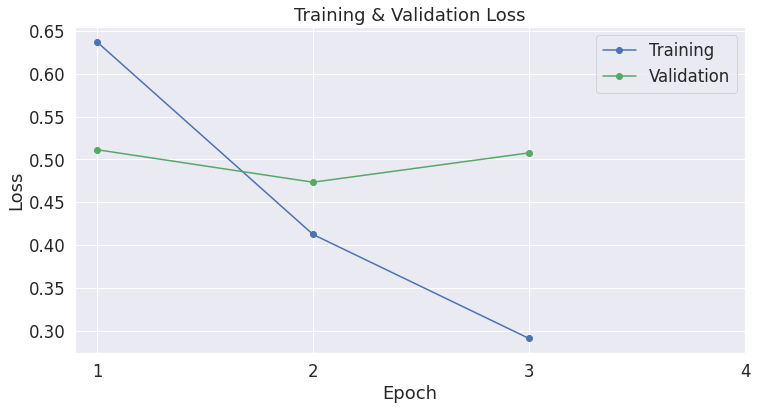

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Test the Classification model

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(test_size))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []
sum_acc = 0

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits
  pred_label = logits.argmax(dim=1)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  pred_label = pred_label.to('cpu').numpy()
  # print('true',label_ids)
  # print('pre',pred_label)
  
  # Store predictions and true labels
  predictions.extend(pred_label.tolist())
  true_labels.extend(label_ids.tolist())
  # print('true',true_labels)
  # print('pre',predictions)
  sum_acc += flat_accuracy(logits, label_ids)
  

test_accuracy = sum_acc/len(test_dataloader)
np.save('true_labels',true_labels,allow_pickle =False)
np.save('predictions',predictions,allow_pickle =False)
print('truelabel',true_labels)
print('prediction',predictions)

print("  Accuracy: {0:.2f}".format(test_accuracy))
print('DONE.')

In [ ]:
print(np.any(np.isnan(predictions)))
print(np.all(np.isfinite(predictions)))
print(np.any(np.isnan(true_labels)))
print(np.all(np.isfinite(true_labels)))

In [ ]:
# save
with open('/content/drive/MyDrive/Colab Notebooks/M4R/BERT tutorial/true_labels_1991.npy', 'w') as f:
    np.savetxt(f, true_labels)

with open('/content/drive/MyDrive/Colab Notebooks/M4R/BERT tutorial/predictions_1991.npy', 'w') as f:
    np.savetxt(f, predictions)

# read
# with open('/content/drive/MyDrive/Colab Notebooks/M4R/BERT tutorial/predictions.npy', 'r') as f:
#     a = np.loadtxt(f)

In [ ]:
print(classification_report(true_labels, predictions))

In [ ]:
plt.figure(figsize=(22, 14), dpi=100)
confusion_mat = confusion_matrix(true_labels, predictions, labels=None, sample_weight=None, normalize=None)
cm = pd.DataFrame(confusion_mat,index=range(len(confusion_mat)),columns=range(len(confusion_mat)))
sns.heatmap(cm.div(np.sum(cm,axis=1), axis='rows'),annot=True, fmt='.2%',cmap="RdPu")
plt.title(year,fontsize=30)
plt.xlabel('PREDICTED',fontsize=30)
plt.ylabel('ACTUAL',fontsize=30)


# 6. Save Fine-Tuned Model

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


NameError: ignored

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the model files to a directory in your Google Drive.
#!cp -r ./model_save/ "/content/drive/MyDrive/Colab Notebooks/M4R/BERT tutorial"
!cp -r ./model_save/ "/content/drive/MyDrive/Karin/"

# 7. Load Fine-Tuned Model

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# model_class = transformers.BertModel
# tokenizer_class = transformers.BertTokenizer

output_dir = '/content/drive/MyDrive/Colab Notebooks/M4R/BERT tutorial/model_save'

# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# import pandas as pd
# import codecs, gc
# import numpy as np
# from sklearn.model_selection import KFold
# from keras_bert import load_trained_model_from_checkpoint, Tokenizer
# from keras.metrics import top_k_categorical_accuracy
# from keras.layers import *
# from keras.callbacks import *
# from keras.models import Model
# import keras.backend as K
# #from keras.optimizers import Adam
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import to_categorical
 
# #读取训练集和测试集
# # train_df=pd.read_csv('data/data_train.csv', sep='\t', names=['id', 'type', 'contents', 'labels']).astype(str)
# # test_df=pd.read_csv('data/data_test.csv', sep='\t', names=['id', 'type', 'contents']).astype(str)
 
# maxlen = 100  #设置序列长度为120，要保证序列长度不超过512
 
# #预训练好的模型
# config_path = 'chinese_roberta_wwm_large_ext_L-24_H-1024_A-16/bert_config.json'
# checkpoint_path = 'chinese_roberta_wwm_large_ext_L-24_H-1024_A-16/bert_model.ckpt'
# dict_path = 'chinese_roberta_wwm_large_ext_L-24_H-1024_A-16/vocab.txt'
 
# #将词表中的词编号转换为字典
# token_dict = {}
# with codecs.open(dict_path, 'r', 'utf8') as reader:
#     for line in reader:
#         token = line.strip()
#         token_dict[token] = len(token_dict)
 
# #重写tokenizer        
# class OurTokenizer(Tokenizer):
#     def _tokenize(self, text):
#         R = []
#         for c in text:
#             if c in self._token_dict:
#                 R.append(c)
#             elif self._is_space(c):
#                 R.append('[unused1]')  # 用[unused1]来表示空格类字符
#             else:
#                 R.append('[UNK]')  # 不在列表的字符用[UNK]表示
#         return R
# tokenizer = OurTokenizer(token_dict)
 
# #让每条文本的长度相同，用0填充
# def seq_padding(X, padding=0):
#     L = [len(x) for x in X]
#     ML = max(L)
#     return np.array([
#         np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
#     ])
 
# #data_generator只是一种为了节约内存的数据方式
# class data_generator:
#     def __init__(self, data, batch_size=32, shuffle=True):
#         self.data = data
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.steps = len(self.data) // self.batch_size
#         if len(self.data) % self.batch_size != 0:
#             self.steps += 1
 
#     def __len__(self):
#         return self.steps
 
#     def __iter__(self):
#         while True:
#             idxs = list(range(len(self.data)))
 
#             if self.shuffle:
#                 np.random.shuffle(idxs)
 
#             X1, X2, Y = [], [], []
#             for i in idxs:
#                 d = self.data[i]
#                 text = d[0][:maxlen]
#                 x1, x2 = tokenizer.encode(first=text)
#                 y = d[1]
#                 X1.append(x1)
#                 X2.append(x2)
#                 Y.append([y])
#                 if len(X1) == self.batch_size or i == idxs[-1]:
#                     X1 = seq_padding(X1)
#                     X2 = seq_padding(X2)
#                     Y = seq_padding(Y)
#                     yield [X1, X2], Y[:, 0, :]
#                     [X1, X2, Y] = [], [], []
 
# #计算top-k正确率,当预测值的前k个值中存在目标类别即认为预测正确                 
# def acc_top2(y_true, y_pred):
#     return top_k_categorical_accuracy(y_true, y_pred, k=2)
 
# #bert模型设置
# def build_bert(nclass):
#     bert_model = load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=None)  #加载预训练模型
 
#     for l in bert_model.layers:
#         l.trainable = True
 
#     x1_in = Input(shape=(None,))
#     x2_in = Input(shape=(None,))
 
#     x = bert_model([x1_in, x2_in])
#     x = Lambda(lambda x: x[:, 0])(x) # 取出[CLS]对应的向量用来做分类
#     p = Dense(nclass, activation='softmax')(x)
 
#     model = Model([x1_in, x2_in], p)
#     model.compile(loss='categorical_crossentropy',
#                   optimizer=Adam(1e-5),    #用足够小的学习率
#                   metrics=['accuracy', acc_top2])
#     print(model.summary())
#     return model
 
# #训练数据、测试数据和标签转化为模型输入格式
# DATA_LIST = []
# for data_row in train_df.iloc[:].itertuples():
#     DATA_LIST.append((data_row.contents, to_categorical(data_row.labels, 3)))
# DATA_LIST = np.array(DATA_LIST)
 
# DATA_LIST_TEST = []
# for data_row in test_df.iloc[:].itertuples():
#     DATA_LIST_TEST.append((data_row.contents, to_categorical(0, 3)))
# DATA_LIST_TEST = np.array(DATA_LIST_TEST)
 
# #交叉验证训练和测试模型
# def run_cv(nfold, data, data_labels, data_test):
#     kf = KFold(n_splits=nfold, shuffle=True, random_state=520).split(data)
#     train_model_pred = np.zeros((len(data), 3))
#     test_model_pred = np.zeros((len(data_test), 3))
 
#     for i, (train_fold, test_fold) in enumerate(kf):
#         X_train, X_valid, = data[train_fold, :], data[test_fold, :]
 
#         model = build_bert(3)
#         early_stopping = EarlyStopping(monitor='val_acc', patience=3)   #早停法，防止过拟合
#         plateau = ReduceLROnPlateau(monitor="val_acc", verbose=1, mode='max', factor=0.5, patience=2) #当评价指标不在提升时，减少学习率
#         checkpoint = ModelCheckpoint('./bert_dump/' + str(i) + '.hdf5', monitor='val_acc',verbose=2, save_best_only=True, mode='max', save_weights_only=True) #保存最好的模型
 
#         train_D = data_generator(X_train, shuffle=True)
#         valid_D = data_generator(X_valid, shuffle=True)
#         test_D = data_generator(data_test, shuffle=False)
#         #模型训练
#         model.fit_generator(
#             train_D.__iter__(),
#             steps_per_epoch=len(train_D),
#             epochs=5,
#             validation_data=valid_D.__iter__(),
#             validation_steps=len(valid_D),
#             callbacks=[early_stopping, plateau, checkpoint],
#         )
 
#         # model.load_weights('./bert_dump/' + str(i) + '.hdf5')
 
#         # return model
#         train_model_pred[test_fold, :] = model.predict_generator(valid_D.__iter__(), steps=len(valid_D), verbose=1)
#         test_model_pred += model.predict_generator(test_D.__iter__(), steps=len(test_D), verbose=1)
 
#         del model
#         gc.collect()   #清理内存
#         K.clear_session()   #clear_session就是清除一个session
#         # break
 
#     return train_model_pred, test_model_pred
 
# #n折交叉验证
# train_model_pred, test_model_pred = run_cv(2, DATA_LIST, None, DATA_LIST_TEST)
 
# test_pred = [np.argmax(x) for x in test_model_pred]
 
# #将测试集预测结果写入文件
# output=pd.DataFrame({'id':test_df.id,'sentiment':test_pred})
# output.to_csv('data/results.csv', index=None)